# LIBIS KMeans Clustering model training
This notebook trains and evaluates Neural KMeans Clustering model and serializing model to a file.

In [1]:
import pandas as pd
import math
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from math import sqrt
from tqdm.notebook import tqdm
from datetime import datetime
from dateutil.relativedelta import relativedelta

from recommenders.utils import kmeans_utils

## Load dataset
Hence, this model is trained on dataset with generated negative samples of orders, typically filename is u.order-3-negatives. Using dataset with generated negative samples saves memory (RAM).

In [2]:
# declare constants
# DATASET = '100k'
# DATASET = '1m'
# DATASET = '5m'
# DATASET = '10m'
DATASET = '20m'

MAX_ORDER_AGE_IN_MONTHS = 12
NUM_NEGATIVES = 4
NUM_CLUSTERS = 16

EXPORT_MODEL = True

In [3]:
# u_cols = ['id', 'age_group', 'education', 'gender', 'is_currently_studying']
users = pd.read_csv(r'data/libis/' + DATASET + '/u.user', sep=',')
users = users[['id', 'age_group', 'education', 'gender']]
# users = users[['id', 'age_group', 'education', 'gender', 'is_currently_studying']]

# r_cols = ['user_id', 'record_id', 'timestamp']
orders = pd.read_csv(r'data/libis/' + DATASET + '/u.order-' + str(NUM_NEGATIVES) + '-negatives', sep=',',
                     parse_dates=['timestamp'])
orders = orders[['user_id', 'record_id', 'timestamp', 'order_count']]
print("order count BEFORE dropping outdated orders: {}".format(len(orders)))
orders = orders[orders['timestamp'] > (datetime.now() - relativedelta(months=MAX_ORDER_AGE_IN_MONTHS))]
print("order count AFTER dropping outdated orders: {}".format(len(orders)))
# m_cols = ['id', 'code', 'leader', 'release_date', 'title', 'genres']
records = pd.read_csv(r'data/libis/' + DATASET + '/u.record', sep=',')
records = records[['id', 'code', 'title', 'genres']]

print(users.columns)

order count BEFORE dropping outdated orders: 92315343
order count AFTER dropping outdated orders: 74819208
Index(['id', 'age_group', 'education', 'gender'], dtype='object')


## Normalize data



In [4]:
kmeans_utils.normalize_users(users_df=users)

normalized_users = users.copy()
# for feature_name in users.columns:
#     if feature_name != 'id':
#         max_value = users[feature_name].max()
#         min_value = users[feature_name].min()
#         normalized_users[feature_name] = (users[feature_name] - min_value) / (max_value - min_value)

display(normalized_users.sample(10))

id  age_group  education  gender
159044  159045        1.0       0.90       0
104435  104436        0.4       0.10       0
129414  129415        1.0       0.70       0
72507    72508        1.0       0.70       0
249859  249860        1.0       0.90       0
57909    57910        1.0       0.75       1
246141  246142        1.0       0.50       0
229848  229849        0.8       0.70       1
246836  246837        0.4       0.10       0
45119    45120        1.0       0.75       0

## Train model


In [5]:
# Train/test split
max_user_id = users['id'].max()
splitter_user_id = math.ceil(max_user_id * 0.95)
# make su splitter_user_id exists
splitter_user_df = users[users['id'] == splitter_user_id]
if splitter_user_df.empty:
    raise Exception("splitter_user by id " + splitter_user_id + " does not exist")

print('splitter_user_id: ' + str(splitter_user_id))

splitter_user_id: 243438


  0%|          | 0/16 [00:00<?, ?it/s]

Cluster	RMSE					MAE
0 		 0.15830093236994355 	 0.050118370378386866
1 		 0.0841343801349911 	 0.01415718784139837
2 		 0.09347795885052243 	 0.017476257581719924
3 		 0.10797524645099842 	 0.02331730769230769
4 		 0.1710073018812371 	 0.05848699459340111
5 		 0.17138171501077498 	 0.05874338448006899
6 		 0.12365936308051664 	 0.030583276154958084
7 		 0.139206076061727 	 0.03875666322500664
8 		 0.1101707112648616 	 0.024275171241211
9 		 0.16455232262557945 	 0.05415493376294554
10 		 0.15569697801891014 	 0.04848309792844195
11 		 0.11997385220266103 	 0.028787450424691906
12 		 0.1120946054274843 	 0.025130401131886786
13 		 0.07729150339326453 	 0.01194795299358204
14 		 0.05994598682708644 	 0.007187042673346441
15 		 0.07886537864464581 	 0.01243949589752671
mean 	 0.12048339451532528 	 0.031502811750055


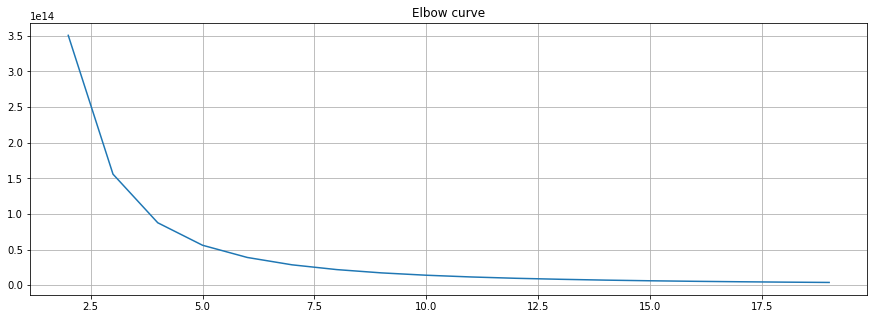

In [6]:
X = normalized_users
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

users_orders = pd.merge(normalized_users, orders, left_on='id', right_on='user_id')

u_train = normalized_users[normalized_users['id'] <= splitter_user_id].drop(columns = 'id')
u_test = normalized_users[normalized_users['id'] > splitter_user_id].drop(columns = 'id')

r_train = orders[orders['user_id'] <= splitter_user_id]
r_test = orders[orders['user_id'] > splitter_user_id]

kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(u_train)
test_labels = kmeans.predict(u_test)

# save the model
if EXPORT_MODEL:
    now = datetime.now()
    now_string = now.strftime("%Y%m%d-%H%M")
    model_filename = "models/model-kmeans-" + DATASET + "-" + now_string + ".pkl"
    import pickle
    pickle.dump(kmeans, open(model_filename, "wb"))

    # load the model
    kmeans = pickle.load(open(model_filename, "rb"))

rmse = []
mae = []

for cluster_number in tqdm(np.unique(test_labels)):
    cluster_users = []

    cluster_orders = r_test.drop(columns='timestamp')
    for i in range(len(test_labels)):
        if test_labels[i] == cluster_number:
            cluster_users.append(float(splitter_user_id + 1 + i))
    cluster_orders = cluster_orders[cluster_orders['user_id'].isin(cluster_users)]
    new_orders = cluster_orders.groupby('record_id', as_index=False)['order_count'].mean().rename(columns={"order_count":"mean_order_count"})
    final_orders = pd.merge(cluster_orders, new_orders, on=['record_id'])
    rmse.append(sqrt(mean_squared_error(final_orders['order_count'], final_orders['mean_order_count'])))
    mae.append(mean_absolute_error(final_orders['order_count'], final_orders['mean_order_count']))
print("Cluster\tRMSE\t\t\t\t\tMAE")
for i in range(len(rmse)):
    print(i,"\t\t",rmse[i],"\t",mae[i])
print("mean","\t",sum(rmse) / np.count_nonzero(rmse),"\t", sum(mae) /  np.count_nonzero(mae))

In [7]:
user_interacted_items = orders.groupby('user_id')['record_id'].apply(list).to_dict()

In [8]:
new_user = pd.DataFrame({
    "id":[users['id'].max()+2],
    "age_group":['3-5'],
    "education":['f'],
    "gender":['MALE']
})
display(new_user)

recommendations = kmeans_utils.generate_recommendations(new_user, users, kmeans, orders, user_interacted_items, records)
display(recommendations)

id age_group education gender
0  256252       3-5         f   MALE

  0%|          | 0/243438 [00:00<?, ?it/s]

C:\Users\kazim\Sources\uni\libis-rs\recommenders\utils\kmeans_utils.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['recommender'] = 'DF'


id                code  \
8279    8288  LIBIS-000000214241   
10141  10152  LIBIS-000000053523   
31054  31072  LIBIS-000000260103   
35564  35585  LIBIS-000000253261   
41583  41614  LIBIS-000000251061   
41584  41615  LIBIS-000000274504   
46516  46550  LIBIS-000000204661   
46732  46767  LIBIS-000000271282   
52538  52574  LIBIS-000000270042   
53279  53316  LIBIS-000000249141   

                                                   title  \
8279   Vytautas Didysis „Žalgirio“ arenoje / Tomas Di...   
10141  Kapitono Bekelnio nuotykiai : pirmasis nuostab...   
31054  Didysis Neitas. Laimingasis talismanas / Linco...   
35564  Kakė Makė ir baisi neteisybė / Lina Žutautė. –...   
41583  Bambukas yra lėėėtas / Benas Bėrantas, Vilija ...   
41584  Tikras vyras : iš „Juzulio istorijų“ : [apsaky...   
46516  Maksas ir 92 musės / Aušra Kiudulaitė. – [Viln...   
46732  Net monstrai tvarkosi! / Jessica Martinello, G...   
52538  Monstras Numeris Du / parašė Tomas Dirgėla. – ...   
53279  Užkeiktoji pono Kuko knyga / Tomas Dirgėla. – ...   

                                       genres recommender  
8279   Grožinė literatūra vaikams ir jaunimui          DF  
10141  Grožinė literatūra vaikams ir jaunimui          DF  
31054  Grožinė literatūra vaikams ir jaunimui          DF  
35564  Grožinė literatūra vaikams ir jaunimui          DF  
41583  Grožinė literatūra vaikams ir jaunimui          DF  
41584  Grožinė literatūra vaikams ir jaunimui          DF  
46516  Grožinė literatūra vaikams ir jaunimui          DF  
46732  Grožinė literatūra vaikams ir jaunimui          DF  
52538  Grožinė literatūra vaikams ir jaunimui          DF  
53279  Grožinė literatūra vaikams ir jaunimui          DF

In [9]:
new_user = pd.DataFrame({
    "id":[users['id'].max()+2],
    "age_group":['12-14'],
    "education":['e'],
    "gender":['MALE']
})
display(new_user)

recommendations = kmeans_utils.generate_recommendations(new_user, users, kmeans, orders, user_interacted_items, records)
display(recommendations)

id age_group education gender
0  256252     12-14         e   MALE

  0%|          | 0/243438 [00:00<?, ?it/s]

C:\Users\kazim\Sources\uni\libis-rs\recommenders\utils\kmeans_utils.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['recommender'] = 'DF'


id                code  \
2899    2905  LIBIS-000000033444   
3126    3132  LIBIS-000000083581   
3194    3200  LIBIS-000000042666   
3884    3890  LIBIS-000000093361   
4504    4510       C1B0000789204   
10214  10225  LIBIS-000000249901   
18057  18072       C1B0002789052   
19734  19749       C1B0003554189   
31054  31072  LIBIS-000000260103   
46334  46368  LIBIS-000000002207   

                                                   title  \
2899   Didysis Neitas rizikuoja / Lincoln Peirce. – V...   
3126   Blogiausi pasaulio vaikai 2 / David Walliams. ...   
3194   Mokšė : blogiausi mano gyvenimo metai / James ...   
3884   Gorlano turnyras : [romanas] / John Flanagan. ...   
4504   Blusyno pasakojimai : [apsakymai] / Gendrutis ...   
10214  Mėnulis ir kitos nelaimės : [romanas] / Gudrun...   
18057  Gorlano griuvėsiai : [romanas] / John Flanagan...   
19734  Makindo apgultis : [romanas] / [John Flanagan]...   
31054  Didysis Neitas. Laimingasis talismanas / Linco...   
46334  Erako išpirka : [romanas] / John Flanagan. – V...   

                                       genres recommender  
2899   Grožinė literatūra vaikams ir jaunimui          DF  
3126   Grožinė literatūra vaikams ir jaunimui          DF  
3194   Grožinė literatūra vaikams ir jaunimui          DF  
3884   Grožinė literatūra vaikams ir jaunimui          DF  
4504   Grožinė literatūra vaikams ir jaunimui          DF  
10214  Grožinė literatūra vaikams ir jaunimui          DF  
18057  Grožinė literatūra vaikams ir jaunimui          DF  
19734  Grožinė literatūra vaikams ir jaunimui          DF  
31054  Grožinė literatūra vaikams ir jaunimui          DF  
46334  Grožinė literatūra vaikams ir jaunimui          DF

In [10]:
new_user = pd.DataFrame({
    "id":[users['id'].max()+2],
    "age_group":['15-17'],
    "education":['d'],
    "gender":['MALE']
})
display(new_user)

recommendations = kmeans_utils.generate_recommendations(new_user, users, kmeans, orders, user_interacted_items, records)
display(recommendations)

id age_group education gender
0  256252     15-17         d   MALE

  0%|          | 0/243438 [00:00<?, ?it/s]

C:\Users\kazim\Sources\uni\libis-rs\recommenders\utils\kmeans_utils.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['recommender'] = 'DF'


id                code  \
10970  10982  LIBIS-000000112989   
25964  25979      C1BLNB03EFEF45   
27760  27775  LIBIS-000000270722   
34577  34598      C1BLNB033BAEEC   
34909  34930  LIBIS-000000158762   
37412  37434  LIBIS-000000216242   
38699  38724      C1BLNB00BC280A   
43589  43621  LIBIS-000000242921   
52217  52253  LIBIS-000000216102   
52252  52288   LIBIS000000003512   

                                                   title              genres  \
10970  Hamletas : tragedija / Viljamas Šekspyras. – K...  Grožinė literatūra   
25964  Balta drobulė : romanas / Antanas Škėma. – Fot...  Grožinė literatūra   
27760  Aušvico lopšinė : romanas / Mario Escobar. – V...  Grožinė literatūra   
34577  Miškais ateina ruduo : romanas / Marius Katili...  Grožinė literatūra   
34909  Anyta : psichologinis trileris / Sally Hepwort...  Grožinė literatūra   
37412  Cilkos kelias : romanas : [romano „Aušvico tat...  Grožinė literatūra   
38699  Karavanas sustoja : fantastinės vokiečių novel...  Grožinė literatūra   
43589  Visiškas užsidarymas : kriminalinis trileris /...  Grožinė literatūra   
52217  Blogio šnabždesys : [trileris] / Donato Carris...  Grožinė literatūra   
52252  Prieš jai dingstant : [detektyvinis romanas] /...  Grožinė literatūra   

      recommender  
10970          DF  
25964          DF  
27760          DF  
34577          DF  
34909          DF  
37412          DF  
38699          DF  
43589          DF  
52217          DF  
52252          DF

In [11]:
new_user = pd.DataFrame({
    "id":[users['id'].max()+2],
    "age_group":['15-17'],
    "education":['d'],
    "gender":['FEMALE']
})
display(new_user)

recommendations = kmeans_utils.generate_recommendations(new_user, users, kmeans, orders, user_interacted_items, records)
display(recommendations)

id age_group education  gender
0  256252     15-17         d  FEMALE

  0%|          | 0/243438 [00:00<?, ?it/s]

C:\Users\kazim\Sources\uni\libis-rs\recommenders\utils\kmeans_utils.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['recommender'] = 'DF'


id                code  \
9750    9761  LIBIS-000000162041   
18674  18689      C1BLNB047DFE8D   
21983  21998  LIBIS-000000165641   
22431  22446         LNB00000458   
23394  23409         LNB030748C9   
25964  25979      C1BLNB03EFEF45   
34577  34598      C1BLNB033BAEEC   
36974  36995      C1BLNB02C69DF8   
44682  44715  LIBIS-000000268708   
54935  54973       C1B0002233746   

                                                   title  \
9750   Mergina iš Italijos : romanas / Lucinda Riley....   
18674  Sename dvare : apsakymai, apysakos / Šatrijos ...   
21983  Vienas iš mūsų meluoja : [romanas] / Karen M. ...   
22431  Altorių šešėly : romanas / Vincas Mykolaitis-P...   
23394  Altorių šešėly : romanas / V. Mykolaitis-Putin...   
25964  Balta drobulė : romanas / Antanas Škėma. – Fot...   
34577  Miškais ateina ruduo : romanas / Marius Katili...   
36974  Sename dvare : apysaka / Šatrijos Ragana. – Vi...   
44682  Mėnesiena ir tu : romanas / Irena Buivydaitė. ...   
54935  Madagaskaras : trijų veiksmų pjesė / Marius Iv...   

                                       genres recommender  
9750                       Grožinė literatūra          DF  
18674                      Grožinė literatūra          DF  
21983  Grožinė literatūra vaikams ir jaunimui          DF  
22431                      Grožinė literatūra          DF  
23394                      Grožinė literatūra          DF  
25964                      Grožinė literatūra          DF  
34577                      Grožinė literatūra          DF  
36974                      Grožinė literatūra          DF  
44682                      Grožinė literatūra          DF  
54935                      Grožinė literatūra          DF

In [12]:
new_user = pd.DataFrame({
    "id":[users['id'].max()+2],
    "age_group":['18-29'],
    "education":['c'],
    "gender":['MALE']
})
display(new_user)

recommendations = kmeans_utils.generate_recommendations(new_user, users, kmeans, orders, user_interacted_items, records)
display(recommendations)

id age_group education gender
0  256252     18-29         c   MALE

  0%|          | 0/243438 [00:00<?, ?it/s]

C:\Users\kazim\Sources\uni\libis-rs\recommenders\utils\kmeans_utils.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['recommender'] = 'DF'


id                code  \
3270    3276  LIBIS-000000257443   
9570    9581  LIBIS-000000259461   
12334  12347  LIBIS-000000268706   
20332  20347  LIBIS-000000270721   
27760  27775  LIBIS-000000270722   
31308  31327  LIBIS-000000258462   
38937  38962  LIBIS-000000239661   
43589  43621  LIBIS-000000242921   
52217  52253  LIBIS-000000216102   
57137  57179  LIBIS-000000269167   

                                                   title  \
3270   Žmogžudystė batsiuvio dirbtuvėje : pirmoji bud...   
9570   Blogio teorija : [detektyvas] / Donato Carrisi...   
12334  Laiko nusikaltimai : avantiūrinis romanas / Si...   
20332  Samarietis : trileris / Mason Cross. – Vilnius...   
27760  Aušvico lopšinė : romanas / Mario Escobar. – V...   
31308  Žudymo sezonas : trileris / Mason Cross. – Vil...   
38937  Mirties skulptorius : [detektyvinis romanas] /...   
43589  Visiškas užsidarymas : kriminalinis trileris /...   
52217  Blogio šnabždesys : [trileris] / Donato Carris...   
57137  999 Aušvico moterys : tikra istorija / Heather...   

                               genres recommender  
3270               Grožinė literatūra          DF  
9570               Grožinė literatūra          DF  
12334              Grožinė literatūra          DF  
20332              Grožinė literatūra          DF  
27760              Grožinė literatūra          DF  
31308              Grožinė literatūra          DF  
38937              Grožinė literatūra          DF  
43589              Grožinė literatūra          DF  
52217              Grožinė literatūra          DF  
57137  Istorija|Teisė. Teisės mokslai          DF

In [13]:
new_user = pd.DataFrame({
    "id":[users['id'].max()+2],
    "age_group":['18-29'],
    "education":['c'],
    "gender":['FEMALE']
})
display(new_user)

recommendations = kmeans_utils.generate_recommendations(new_user, users, kmeans, orders, user_interacted_items, records)
display(recommendations)

id age_group education  gender
0  256252     18-29         c  FEMALE

  0%|          | 0/243438 [00:00<?, ?it/s]

C:\Users\kazim\Sources\uni\libis-rs\recommenders\utils\kmeans_utils.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['recommender'] = 'DF'


id                code  \
9750    9761  LIBIS-000000162041   
16627  16642  LIBIS-000000279626   
26718  26733  LIBIS-000000181441   
36617  36638  LIBIS-000000138285   
37192  37214  LIBIS-000000211242   
39326  39351  LIBIS-000000200661   
44682  44715  LIBIS-000000268708   
50154  50189  LIBIS-000000204783   
53460  53497  LIBIS-000000109941   
58958  59001  LIBIS-000000270723   

                                                   title              genres  \
9750   Mergina iš Italijos : romanas / Lucinda Riley....  Grožinė literatūra   
16627  Dingusi sesuo : Meropės istorija : romanas / L...  Grožinė literatūra   
26718  Angelų medis : romanas / Lucinda Riley. – Viln...  Grožinė literatūra   
36617  Rožių dvaras : romanas / Irena Buivydaitė. – V...  Grožinė literatūra   
37192  Drugelių kambarys : romanas / Lucinda Riley. –...  Grožinė literatūra   
39326  Ten, kur gieda vėžiai : romanas / Delia Owens....  Grožinė literatūra   
44682  Mėnesiena ir tu : romanas / Irena Buivydaitė. ...  Grožinė literatūra   
50154  Vasaros vaikas : [romanas] / Diane Chamberlain...  Grožinė literatūra   
53460  Helenos paslaptis : romanas / Lucinda Riley. –...  Grožinė literatūra   
58958  Meilės laiškas : romanas / Lucinda Riley. – Vi...  Grožinė literatūra   

      recommender  
9750           DF  
16627          DF  
26718          DF  
36617          DF  
37192          DF  
39326          DF  
44682          DF  
50154          DF  
53460          DF  
58958          DF

In [14]:
new_user = pd.DataFrame({
    "id":[users['id'].max()+2],
    "age_group":['60-69'],
    "education":['a'],
    "gender":['FEMALE']
})
display(new_user)

recommendations = kmeans_utils.generate_recommendations(new_user, users, kmeans, orders, user_interacted_items, records)
display(recommendations)

id age_group education  gender
0  256252     60-69         a  FEMALE

  0%|          | 0/243438 [00:00<?, ?it/s]

C:\Users\kazim\Sources\uni\libis-rs\recommenders\utils\kmeans_utils.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['recommender'] = 'DF'


id                   code  \
14496  14510     LIBIS-000000268183   
16627  16642     LIBIS-000000279626   
23649  23664     LIBIS-000000238541   
27760  27775     LIBIS-000000270722   
35341  35362  C15LIBIS-000000269901   
37192  37214     LIBIS-000000211242   
39326  39351     LIBIS-000000200661   
44682  44715     LIBIS-000000268708   
58958  59001     LIBIS-000000270723   
59630  59673     LIBIS-000000262541   

                                                   title              genres  \
14496  Maloningoji žemė : romanas / William Kent Krue...  Grožinė literatūra   
16627  Dingusi sesuo : Meropės istorija : romanas / L...  Grožinė literatūra   
23649  Išsvajota dukra : [romanas] / Diane Chamberlai...  Grožinė literatūra   
27760  Aušvico lopšinė : romanas / Mario Escobar. – V...  Grožinė literatūra   
35341  Petro imperatorė II : [istorinis romanas] / Kr...  Grožinė literatūra   
37192  Drugelių kambarys : romanas / Lucinda Riley. –...  Grožinė literatūra   
39326  Ten, kur gieda vėžiai : romanas / Delia Owens....  Grožinė literatūra   
44682  Mėnesiena ir tu : romanas / Irena Buivydaitė. ...  Grožinė literatūra   
58958  Meilės laiškas : romanas / Lucinda Riley. – Vi...  Grožinė literatūra   
59630  Ispaniška vasara : romanas / Karen Swan. – Vil...  Grožinė literatūra   

      recommender  
14496          DF  
16627          DF  
23649          DF  
27760          DF  
35341          DF  
37192          DF  
39326          DF  
44682          DF  
58958          DF  
59630          DF